# Imports

In [7]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector

# Einleitung

Einfacher parametrisierter Schaltkreis, mit zwei parametrisierten Gates, ein single-qubit z-Rotations Gate mit variablen Winkel $\theta$ und ein two-qubit z-Rotations Gate auch mit der Winkelvariable $\theta$.

In [6]:
theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.rz(theta, 0)
qc.crz(theta, 0, 1)
qc.draw()

┌───────┐         
q_0: ┤ Rz(θ) ├────■────
     └───────┘┌───┴───┐
q_1: ─────────┤ Rz(θ) ├
              └───────┘

Um parametrisierte Quantum Schaltkreise für ML zu nutzen, müssen sie gut verallgemeinern können.
Das bedeutet, dass der Schaltkreis in der Lage sein sollte, eine signifikante Teilmenge der Zustände innerhalb des Hilbert-Raums der Ausgabe zu erzeugen.
Und der SK sollte die Qubits auch entanglen um einfaches simulieren auf klassischen Comp. zu verhindern. 

## Aussagekraft

Die Aussagekraft einer param. QS ist im Wesentlichen die Abdeckung des Hilbert-Raums durch den Hypothesenraum der Schaltung.

Bloch Kugel: Grafisch-geometrische Darstellung der Zustände eines Qubits

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Schaltung erstellen
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Schaltung A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)


qc_A.draw()

┌───┐┌───────┐
q: ┤ H ├┤ Rz(θ) ├
   └───┘└───────┘

In [13]:
# Schaltung B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)

qc_B.draw()

┌───┐┌───────┐┌───────┐
q: ┤ H ├┤ Rz(θ) ├┤ Rx(Φ) ├
   └───┘└───────┘└───────┘

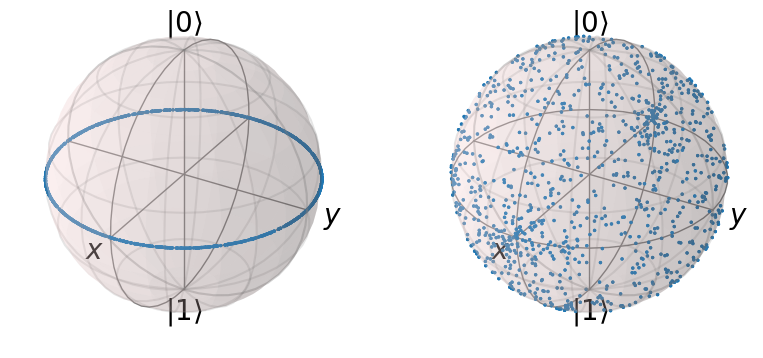

In [14]:
# Der Parameterraum für die beiden Parameter theta und pi wird einheitlich abgetastet
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Die Werteliste werden als Zustandsvektoren auf der Bloch Kugel gezeichnet
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def draw_to_bloch(state_vec):
    # Zustandsvektoren zu Punkte auf Bloch Sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch Plotting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Zustandsvektoren für A und B für die 1000 Parameter bilden und zur Bloch Kugel hinzufügen
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))


b1.show()
b2.show()

A: Zustände nur auf dem Äquator der Bloch-Kugel, einheitlich.
B: Wegen zusätzlichem Rotations-Gate kann ganze Kugel abgedeckt werden, aber nicht mehr einheitlich. 
-> Schaltung B größere Aussagekraft als Scahltung A

# Data Encoding